In [260]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import warnings
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from scipy.stats import kurtosis
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from hyperopt import fmin, tpe, hp, Trials

# import xgboost as xgb
# from sklearn.metrics import mean_squared_error, r2_score

# 忽略所有警告
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
plt.rcParams['font.sans-serif'] = ['SimHei']  # 使用黑体，或者使用你系统上可用的其他字体
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

In [261]:
#利用AskPrice1和BidPrice1计算价格的平均值，进而计算分钟频的收益率
def mid_price(df):
    mid = (df['AskPrice1'] + df['BidPrice1'])/2
    mid = mid.astype(float)
    return mid


In [262]:
def weighted_price(df):
    weighted = (df['AskPrice1']*df['AskVolume1'] + df['BidPrice1']*df['BidVolume1'])/(df['AskVolume1'] + df['BidVolume1'])
    weighted = weighted.astype(float)
    return weighted

In [263]:
# 构造滞后特征
def create_lagged_features(df, window_size1,window_size2):
    for i in range(1, window_size1 + 1):
        df[f'factor_lag{window_size1}_{i}'] = df['factor'].shift(i)
    for j in range(1, window_size2 + 1):
        df[f'factor1_lag{window_size2}_{j}'] = df['factor1'].shift(j)
    df = df.fillna(0,inplace=True)  # 删除NaN行，因为前几行会有缺失值
    return df

In [264]:
def calculate_ic(factors, returns):
    """
    计算单因子或多因子模型的IC。
    :param factors: 预测因子,可以是单因子,也可以是多因子拟合后得到的y-pred。
    :param returns: 实际的未来回报,Series 格式。
    :return: 信息系数(IC)
    """
    # 计算皮尔逊相关系数
    ic, _ = pearsonr(factors, returns)
    return ic

In [265]:
#由于日盘无法获取前一期夜盘数据，夜盘也无法获取前一期日盘的数据
def process_day(group, prev_period, back_period):
    split_time = pd.to_datetime(group['trading_date'].iloc[0].strftime('%Y-%m-%d') + ' 08:00:00')
    before_8 = group[group['exchange_time'] < split_time].iloc[prev_period:-back_period]
    after_8 = group[group['exchange_time'] >= split_time].iloc[prev_period:-back_period]
    return pd.concat([before_8, after_8])


In [266]:
def calculate_ic_multiple_factors(factors, returns):
    
    # 计算多因子模型的IC，通过回归预测值与实际收益的相关系数。
    
    # 参数:
    # factors (DataFrame): 每列为一个因子，行是样本（股票、日期等）。
    # returns (array-like): 实际的未来收益，和因子数据对应。
    
    # 返回:
    # float: 信息系数（IC），即回归预测值与实际收益的皮尔逊相关系数。
    
    # 创建回归模型
    model = LinearRegression()
    
    # 进行回归训练：因子作为自变量，收益作为因变量
    model.fit(factors, returns)
    
    # 获取回归预测值
    predicted_returns = model.predict(factors)
    
    # 计算预测值与 实际收益的相关系数（即IC）
    ic, _ = pearsonr(predicted_returns, returns)
    
    return ic


In [267]:
"""def calculate_ic_multiple_factors(factors, returns):
    
    # 计算多因子模型的IC，通过回归预测值与实际收益的相关系数。
    
    # 参数:
    # factors (DataFrame): 每列为一个因子，行是样本（股票、日期等）。
    # returns (array-like): 实际的未来收益，和因子数据对应。
    
    # 返回:
    # float: 信息系数（IC），即回归预测值与实际收益的皮尔逊相关系数。
    
    # 创建弹性网回归模型，并通过交叉验证自动选择最优的 alpha 和 l1_ratio
    elastic_net_model = ElasticNetCV(alphas=np.logspace(-6, 6, 13), l1_ratio=np.linspace(0, 1, 11), cv=5)

    # 进行回归训练：因子作为自变量，收益作为因变量
    elastic_net_model.fit(factors, returns)

    # 获取回归预测值
    predicted_returns = elastic_net_model.predict(factors)

    # 计算预测值与实际收益的相关系数（即IC）
    ic, _ = pearsonr(predicted_returns, returns)

    # 输出结果
    print(f"最优的正则化参数 alpha: {elastic_net_model.alpha_}")
    print(f"最优的 L1/L2 比例 (l1_ratio): {elastic_net_model.l1_ratio_}")
    print(f"信息系数（IC）：{ic}")

    return ic"""

'def calculate_ic_multiple_factors(factors, returns):\n    \n    # 计算多因子模型的IC，通过回归预测值与实际收益的相关系数。\n    \n    # 参数:\n    # factors (DataFrame): 每列为一个因子，行是样本（股票、日期等）。\n    # returns (array-like): 实际的未来收益，和因子数据对应。\n    \n    # 返回:\n    # float: 信息系数（IC），即回归预测值与实际收益的皮尔逊相关系数。\n    \n    # 创建弹性网回归模型，并通过交叉验证自动选择最优的 alpha 和 l1_ratio\n    elastic_net_model = ElasticNetCV(alphas=np.logspace(-6, 6, 13), l1_ratio=np.linspace(0, 1, 11), cv=5)\n\n    # 进行回归训练：因子作为自变量，收益作为因变量\n    elastic_net_model.fit(factors, returns)\n\n    # 获取回归预测值\n    predicted_returns = elastic_net_model.predict(factors)\n\n    # 计算预测值与实际收益的相关系数（即IC）\n    ic, _ = pearsonr(predicted_returns, returns)\n\n    # 输出结果\n    print(f"最优的正则化参数 alpha: {elastic_net_model.alpha_}")\n    print(f"最优的 L1/L2 比例 (l1_ratio): {elastic_net_model.l1_ratio_}")\n    print(f"信息系数（IC）：{ic}")\n\n    return ic'

In [268]:
table = pd.read_parquet('ag')


table['trading_date'] = pd.to_datetime(table['trading_date']) 

# 设置开始和结束时间
start_time_0 = pd.to_datetime('2023-07-01')
end_time_0 = pd.to_datetime('2024-06-30')

# 提取时间范围内的数据
table = table[(table['trading_date'] >= start_time_0) & (table['trading_date'] <= end_time_0)]

# 当 AskPrice1 为 0 时，用 BidPrice1 替换
table['AskPrice1'] = table['AskPrice1'].where(table['AskPrice1'] != 0, table['BidPrice1'])

# 当 BidPrice1 为 0 时，用 AskPrice1 替换
table['BidPrice1'] = table['BidPrice1'].where(table['BidPrice1'] != 0, table['AskPrice1'])

In [269]:
table['current_volume'] = table['Volume'].diff()
table['Position Increase'] = table['OpenInterest'].diff()
table['current_turnover'] = table['Turnover'].diff()
table['current_avg_price'] = table['current_turnover']/(table['current_volume']*15)
table['weighted_price'] = weighted_price(table)
table['mid_price'] = mid_price(table)


In [270]:
#判断是否主动买卖
table['主动买or主动卖'] = '被动买卖'
table.loc[table['last'] >= table['AskPrice1'].shift(1),'主动买or主动卖'] = '主动买'
table.loc[table['last'] <= table['BidPrice1'].shift(1),'主动买or主动卖'] = '主动卖'

In [271]:
#这500ms中成交的价格对为Low Price和High Price（假设只有两个价格成交，这里的价格对指的是当期的价格）
#思考：用当期数据比较合理还是用前一期数据比较合理？
#table['Low Price比例'] = (table['current_avg_price'] - table['AskPrice1'])/(table['BidPrice1'] - table['AskPrice1'])
#table['High Price比例'] = 1 - table['Low Price比例']
#'High Price比例'反映高价交易的成交比例；'Low Price比例'反映低价交易的成交比例
#主动买：当High Price比例大于1时，说明交易以超过卖一价达成，即交易的买一价可能是卖二、卖三，反映市场的看多力量；如果出现Low Price比例大于1，可能是因为出现大单，在切片时间段内价格持续快速上涨，导致此时的买二价可能是原来的卖二、卖三等
#主动卖：当Low Price比例大于1时，说明交易以低于买一价达成，即交易的卖一价可能是买二、买三，反映市场的看空力量；如果出现High Price比例大于1，也可能是因为出现大单，在切片时间段内价格持续快速下跌，导致此时的卖二价可能是原来的买二、买三等

In [272]:
#构造基础信息：成交价格对，以及以高价成交和低价成交的比例
table['前一期成交价格对'] = 'BidPrice1 and AskPrice1'
table['前一期Low Price比例'] = (table['current_avg_price'] - table['AskPrice1'].shift(1))/(table['BidPrice1'].shift(1) - table['AskPrice1'].shift(1))
table['前一期High Price比例'] = 1 - table['前一期Low Price比例']
table.loc[(table['前一期High Price比例'] > 1),'前一期成交价格对'] = 'AskPrice1 and AskPrice2'
table.loc[(table['前一期Low Price比例'] > 1),'前一期成交价格对'] = 'BidPrice2 and BidPrice1'
table['前一期Low Price比例'].loc[(table['前一期High Price比例'] > 1)] = (table['current_avg_price'] - table['AskPrice2'].shift(1))/(table['AskPrice1'].shift(1) - table['AskPrice2'].shift(1))
table['前一期Low Price比例'].loc[(table['前一期Low Price比例'] > 1)] = (table['current_avg_price'] - table['BidPrice1'].shift(1))/(table['BidPrice2'].shift(1) - table['BidPrice1'].shift(1))
table['前一期High Price比例'] = 1 - table['前一期Low Price比例']
table.loc[(table['前一期High Price比例'] > 1),'前一期成交价格对'] = 'AskPrice2 and AskPrice3'
table.loc[(table['前一期Low Price比例'] > 1),'前一期成交价格对'] = 'BidPrice3 and BidPrice2'
table['前一期Low Price比例'].loc[(table['前一期High Price比例'] > 1)] = (table['current_avg_price'] - table['AskPrice3'].shift(1))/(table['AskPrice2'].shift(1) - table['AskPrice3'].shift(1))
table['前一期Low Price比例'].loc[(table['前一期Low Price比例'] > 1)] = (table['current_avg_price'] - table['BidPrice2'].shift(1))/(table['BidPrice3'].shift(1) - table['BidPrice2'].shift(1))
table['前一期High Price比例'] = 1 - table['前一期Low Price比例']
table.loc[(table['前一期High Price比例'] > 1),'前一期成交价格对'] = 'AskPrice3 and AskPrice4'
table['前一期Low Price比例'].loc[(table['前一期High Price比例'] > 1)] = (table['current_avg_price'] - table['AskPrice4'].shift(1))/(table['AskPrice3'].shift(1) - table['AskPrice4'].shift(1))
table['前一期High Price比例'] = 1-table['前一期Low Price比例']

In [273]:
table['BidVolume'] = table[['BidVolume1','BidVolume2','BidVolume3','BidVolume4','BidVolume5']].sum(axis=1)
table['AskVolume'] = table[['AskVolume1','AskVolume2','AskVolume3','AskVolume4','AskVolume5']].sum(axis=1)
table['Order_Volume'] = table['BidVolume'] + table['AskVolume']

In [274]:
#计算收益，即y值
table['return'] = -mid_price(table).diff(-120)


In [275]:
#处理缺失值
table['前一期Low Price比例'].replace([np.inf, -np.inf], np.nan, inplace=True)
table['前一期High Price比例'].replace([np.inf, -np.inf], np.nan, inplace=True)

table['current_volume'].fillna(0,inplace=True)
table['Position Increase'].fillna(0,inplace=True)
table['current_turnover'].fillna(0,inplace=True)
table['current_avg_price'].fillna(method='ffill',inplace=True)
table['weighted_price'].fillna(method='ffill',inplace=True)
#table['Low Price比例'].fillna(0,inplace=True)
#table['High Price比例'].fillna(0,inplace=True)
table['前一期Low Price比例'].fillna(0,inplace=True)
table['前一期High Price比例'].fillna(0,inplace=True)
table['return'].fillna(0,inplace=True)



In [276]:
# table['Difference in Trading Volume'] = table['current_volume']*(table['High Price比例'] -table['Low Price比例'])
# table['factor3'] = (table['Difference in Trading Volume'] - table['Difference in Trading Volume'].mean())/table['Difference in Trading Volume'].std()

In [277]:
#因子：前一期不同成交价格比例之差
#同时我们对成交价格对不为“AskPrice1 and BidPrice1”的数据进行惩罚。
#如果全都以买价成交，说明有下降趋势，我们给他一个负的惩罚项；如果全都以卖价成交，说明有上升趋势，我们给一个正的惩罚项。

# table['Difference in Trading Pct'] = table['前一期High Price比例'] - table['前一期Low Price比例']
# table['New_Difference in Trading Pct'] = 0
# table['New_Difference in Trading Pct'].loc[table['前一期成交价格对'] == 'BidPrice1 and AskPrice1'] = table['Difference in Trading Pct']
# table['New_Difference in Trading Pct'].loc[(table['前一期成交价格对'] == 'AskPrice1 and AskPrice2')] = 0.5 + table['Difference in Trading Pct']
# table['New_Difference in Trading Pct'].loc[(table['前一期成交价格对'] == 'AskPrice2 and AskPrice3')] = 0.8 + table['Difference in Trading Pct']
# table['New_Difference in Trading Pct'].loc[(table['前一期成交价格对'] == 'AskPrice3 and AskPrice4')] = 2.7 + table['Difference in Trading Pct']
# table['New_Difference in Trading Pct'].loc[(table['前一期成交价格对'] == 'BidPrice2 and BidPrice1')] = -0.5 + table['Difference in Trading Pct']
# table['New_Difference in Trading Pct'].loc[(table['前一期成交价格对'] == 'BidPrice3 and BidPrice2')] = -0.8 + table['Difference in Trading Pct']
# table['New_Difference in Trading Pct'].loc[(table['前一期成交价格对'] == 'BidPrice4 and BidPrice3')] = -2.7 + table['Difference in Trading Pct']
# table['factor'] = table['New_Difference in Trading Pct']
table['Difference in Trading Pct'] = table['前一期High Price比例'] - table['前一期Low Price比例']
table['New_Difference in Trading Pct'] = 0
table['New_Difference in Trading Pct'].loc[table['前一期成交价格对'] == 'BidPrice1 and AskPrice1'] = table['Difference in Trading Pct']
table['New_Difference in Trading Pct'].loc[(table['前一期成交价格对'] == 'AskPrice1 and AskPrice2')] = 0.1 + table['Difference in Trading Pct']
table['New_Difference in Trading Pct'].loc[(table['前一期成交价格对'] == 'AskPrice2 and AskPrice3')] = 0.5 + table['Difference in Trading Pct']
table['New_Difference in Trading Pct'].loc[(table['前一期成交价格对'] == 'AskPrice3 and AskPrice4')] = 1.0 + table['Difference in Trading Pct']
table['New_Difference in Trading Pct'].loc[(table['前一期成交价格对'] == 'BidPrice2 and BidPrice1')] = -0.1 + table['Difference in Trading Pct']
table['New_Difference in Trading Pct'].loc[(table['前一期成交价格对'] == 'BidPrice3 and BidPrice2')] = -0.5 + table['Difference in Trading Pct']
table['New_Difference in Trading Pct'].loc[(table['前一期成交价格对'] == 'BidPrice4 and BidPrice3')] = -1.0 + table['Difference in Trading Pct']
table['factor'] = table['New_Difference in Trading Pct']
# table['factor'] = (table['Difference in Trading Pct'] -  table['Difference in Trading Pct'].mean())/table['Difference in Trading Pct'].std()
# table['factor'] = table['前一期High Price比例'] - table['前一期Low Price比例']

In [278]:
#因子：主动买卖信号
# table['factor1_weight'] = 0
# table['factor1_weight'].loc[table['主动买or主动卖']=='主动买'] = 0.2
# table['factor1_weight'].loc[(table['前一期成交价格对'] == 'AskPrice1 and AskPrice2')] = 1.2
# table['factor1_weight'].loc[(table['前一期成交价格对'] == 'AskPrice2 and AskPrice3')] = 1.8
# table['factor1_weight'].loc[table['主动买or主动卖']=='主动卖'] = -0.2
# table['factor1_weight'].loc[(table['前一期成交价格对'] == 'BidPrice2 and BidPrice1')] = -1.2
# table['factor1_weight'].loc[(table['前一期成交价格对'] == 'BidPrice3 and BidPrice2')] = -1.8
# table['factor1'] = table['factor1_weight']*table['current_volume']
# table['factor1'] = table['factor1'] - table['factor1'].rolling(110).mean()
table['factor1_weight'] = 0
table['factor1_weight'].loc[table['主动买or主动卖']=='主动买'] = 1.0
table['factor1_weight'].loc[(table['前一期成交价格对'] == 'AskPrice1 and AskPrice2')] = 1.9
table['factor1_weight'].loc[(table['前一期成交价格对'] == 'AskPrice2 and AskPrice3')] = 3.0
table['factor1_weight'].loc[table['主动买or主动卖']=='主动卖'] = -1.0
table['factor1_weight'].loc[(table['前一期成交价格对'] == 'BidPrice2 and BidPrice1')] = -1.9
table['factor1_weight'].loc[(table['前一期成交价格对'] == 'BidPrice3 and BidPrice2')] = -3.0
table['factor1'] = table['factor1_weight']*table['current_volume']
table['factor1'] = table['factor1'] - table['factor1'].rolling(74).mean()
# table['factor1'] = 10 * ((table['factor1'] - table['factor1'].rolling(window=10).mean())**4).rolling(10).sum()/(((table['factor1'] - table['factor1'].rolling(window=10).mean())**2)**2).rolling(10).sum()
# table['factor1'] = np.sqrt(np.abs(table['factor1'])) * np.sign(table['factor1'])



In [279]:
#想法是用短期std()相对于长期std()来反映比较大的波动，但是std()无法反映变动方向，于是考虑加入主动买卖信号来判断方向
#用“-1、0、1”做解释变量还是用其他指标
#首先尝试，std（）的相对强弱* factor1
# table['std_20_tick'] = table['current_volume'].rolling(20).std()
# table['std_125_tick'] = table['current_volume'].rolling(125).std()
# table['factor2'] = (table['std_20_tick']/table['std_125_tick']) * table['factor1_weight']
# table['factor2'] = table['factor2'] - table['factor2'].rolling(110).mean()
table['std_20_tick'] = table['current_volume'].rolling(29).std()
table['std_125_tick'] = table['current_volume'].rolling(38).std()
table['factor2'] = (table['std_20_tick']/table['std_125_tick']) * table['factor1_weight']





In [280]:
# table['factor3'] = table['current_avg_price'] - table['mid_price']
# table['factor3'] = table['factor3']-table['factor3'].rolling(110).mean()

table['factor3'] = table['current_avg_price'] - table['mid_price']
table['factor3'] = table['factor3']-table['factor3'].rolling(105).mean()

# table['factor3'] = table['current_avg_price'] - table['mid_price']
# table[['factor3','return']].corr()

In [281]:
# table['factor4'] = (table['Order_Volume'].diff()*table['current_avg_price'])/(table['current_avg_price'].diff()*table['Order_Volume'])

In [282]:
cols_to_standardize = ['factor','factor1','factor2','factor3']
table[cols_to_standardize] = table[cols_to_standardize].apply(lambda x: (x - x.mean()) / x.std())

In [283]:
# # table['factor4'].replace([np.inf, -np.inf], np.nan, inplace=True)
# table['factor'].fillna(0,inplace=True)
# table['factor1'].fillna(0,inplace=True)
# table['factor2'].fillna(0,inplace=True)
# table['factor3'].fillna(0,inplace=True)
# # table['factor4'].fillna(0,inplace=True)

In [284]:
table['transform_factor2'] = np.log(abs(3/(table['factor2']+1.5)-1))/(-25)
table['factor2'] = table['transform_factor2'] * (np.abs(table['transform_factor2']) <= 1.5) + table['factor2']*(np.abs(table['transform_factor2']>1.5))

In [285]:
table['factor2'].replace([np.inf, -np.inf], np.nan, inplace=True)
table['factor'].fillna(0,inplace=True)
table['factor1'].fillna(0,inplace=True)
table['factor2'].fillna(0,inplace=True)
table['factor3'].fillna(0,inplace=True)


In [286]:
table.iloc[2395:2450]

,order_book_id,exchange_time,trading_date,open,last,high,low,prev_settlement,prev_close,Volume,OpenInterest,Turnover,limit_up,limit_down,AskPrice1,AskPrice2,AskPrice3,AskPrice4,AskPrice5,BidPrice1,BidPrice2,BidPrice3,BidPrice4,BidPrice5,AskVolume1,AskVolume2,AskVolume3,AskVolume4,AskVolume5,BidVolume1,BidVolume2,BidVolume3,BidVolume4,BidVolume5,change_rate,current_volume,Position Increase,current_turnover,current_avg_price,weighted_price,mid_price,主动买or主动卖,前一期成交价格对,前一期Low Price比例,前一期High Price比例,BidVolume,AskVolume,Order_Volume,return,Difference in Trading Pct,New_Difference in Trading Pct,factor,factor1_weight,factor1,std_20_tick,std_125_tick,factor2,factor3,transform_factor2
21364094,AG2308,2023-06-30 21:20:08.000,2023-07-03,5428.0,5441.0,5446.0,5427.0,5432.0,5439.0,36245.0,258256.0,2.955518e+09,5920.0,4943.0,5442.0,5443.0,5444.0,5445.0,5446.0,5441.0,5440.0,5439.0,5438.0,5437.0,31.0,116.0,184.0,192.0,112.0,73.0,130.0,141.0,183.0,231.0,0.001657,0.0,0.0,0.0,5441.000000,5441.298077,5441.5,主动卖,BidPrice1 and AskPrice1,0.000000,0.000000,758.0,635.0,1393.0,3.0,0.000000,0.000000,0.000274,-1.0,0.000040,19.317034,16.644860,-0.077297,-1.050514,-0.077297
21364095,AG2308,2023-06-30 21:20:08.500,2023-07-03,5428.0,5443.0,5446.0,5427.0,5432.0,5439.0,36287.0,258267.0,2.958947e+09,5920.0,4943.0,5443.0,5444.0,5445.0,5446.0,5447.0,5442.0,5441.0,5440.0,5439.0,5438.0,121.0,166.0,192.0,112.0,66.0,22.0,74.0,130.0,141.0,183.0,0.002025,42.0,11.0,3428625.0,5442.261905,5442.846154,5442.5,主动买,AskPrice1 and AskPrice2,0.738095,0.261905,550.0,657.0,1207.0,2.0,-0.476190,-0.376190,-0.485579,1.9,0.009789,20.348140,16.875567,0.065360,-0.562086,0.065360
21364096,AG2308,2023-06-30 21:20:09.000,2023-07-03,5428.0,5443.0,5446.0,5427.0,5432.0,5439.0,36287.0,258267.0,2.958947e+09,5920.0,4943.0,5443.0,5444.0,5445.0,5446.0,5447.0,5442.0,5441.0,5440.0,5439.0,5438.0,119.0,184.0,192.0,112.0,66.0,9.0,77.0,142.0,141.0,183.0,0.002025,0.0,0.0,0.0,5442.261905,5442.929688,5442.5,主动买,BidPrice1 and AskPrice1,0.000000,0.000000,552.0,673.0,1225.0,2.0,0.000000,0.000000,0.000274,1.0,-0.000092,20.348140,16.897986,0.084069,-0.565299,0.084069
21364097,AG2308,2023-06-30 21:20:09.500,2023-07-03,5428.0,5443.0,5446.0,5427.0,5432.0,5439.0,36287.0,258267.0,2.958947e+09,5920.0,4943.0,5443.0,5444.0,5445.0,5446.0,5447.0,5442.0,5441.0,5440.0,5439.0,5438.0,100.0,201.0,192.0,112.0,66.0,6.0,93.0,127.0,142.0,183.0,0.002025,0.0,0.0,0.0,5442.261905,5442.943396,5442.5,主动买,BidPrice1 and AskPrice1,0.000000,0.000000,551.0,671.0,1222.0,2.0,0.000000,0.000000,0.000274,1.0,-0.000050,20.348140,16.788141,0.085130,-0.560249,0.085130
21364098,AG2308,2023-06-30 21:20:10.000,2023-07-03,5428.0,5443.0,5446.0,5427.0,5432.0,5439.0,36287.0,258267.0,2.958947e+09,5920.0,4943.0,5443.0,5444.0,5445.0,5446.0,5447.0,5442.0,5441.0,5440.0,5439.0,5438.0,100.0,213.0,191.0,112.0,67.0,38.0,105.0,127.0,142.0,183.0,0.002025,0.0,0.0,0.0,5442.261905,5442.724638,5442.5,主动买,BidPrice1 and AskPrice1,0.000000,0.000000,595.0,683.0,1278.0,2.5,0.000000,0.000000,0.000274,1.0,-0.000044,20.348140,16.801509,0.084999,-0.554872,0.084999
21364099,AG2308,2023-06-30 21:20:10.500,2023-07-03,5428.0,5442.0,5446.0,5427.0,5432.0,5439.0,36354.0,258298.0,2.964417e+09,5920.0,4943.0,5443.0,5444.0,5445.0,5446.0,5447.0,5442.0,5441.0,5440.0,5439.0,5438.0,49.0,229.0,191.0,112.0,67.0,21.0,106.0,141.0,142.0,183.0,0.001841,67.0,31.0,5469960.0,5442.746269,5442.700000,5442.5,主动卖,BidPrice1 and AskPrice1,0.253731,0.746269,593.0,648.0,1241.0,3.0,0.492537,0.492537,0.636389,-1.0,-0.008216,23.038199,17.403904,-0.101238,0.347902,-0.101238
21364100,AG2308,2023-06-30 21:20:11.000,2023-07-03,5428.0,5442.0,5446.0,5427.0,5432.0,5439.0,36371.0,258315.0,2.965804e+09,5920.0,4943.0,5443.0,5444.0,5445.0,5446.0,5447.0,5442.0,5441.0,5440.0,5439.0,5438.0,69.0,207.0,191.0,112.0,67.0,32.0,106.0,138.0,142.0,186.0,0.001841,17.0,17.0,1387725.0,5442.058824,5442.683168,5442.5,主动卖,BidPrice1 and AskPrice1,0.941176,0.058824,604.0,646.0,1250.0,3.0,-0.882353,-0.882353,-1.139291,-1.0,-0.002002,22.978143,

In [287]:
table['exchange_time'] = pd.to_datetime(table['exchange_time'])  # 确保 exchange_time 是 datetime 类型

# 设置开始和结束时间
start_time = pd.to_datetime('2023-12-01 09:09:00.500')
end_time = pd.to_datetime('2023-12-01 09:48:00.500')

# 提取时间范围内的数据
filtered_table = table[(table['exchange_time'] >= start_time) & (table['exchange_time'] <= end_time)]

In [288]:
filtered_table.fillna(0,inplace=True)

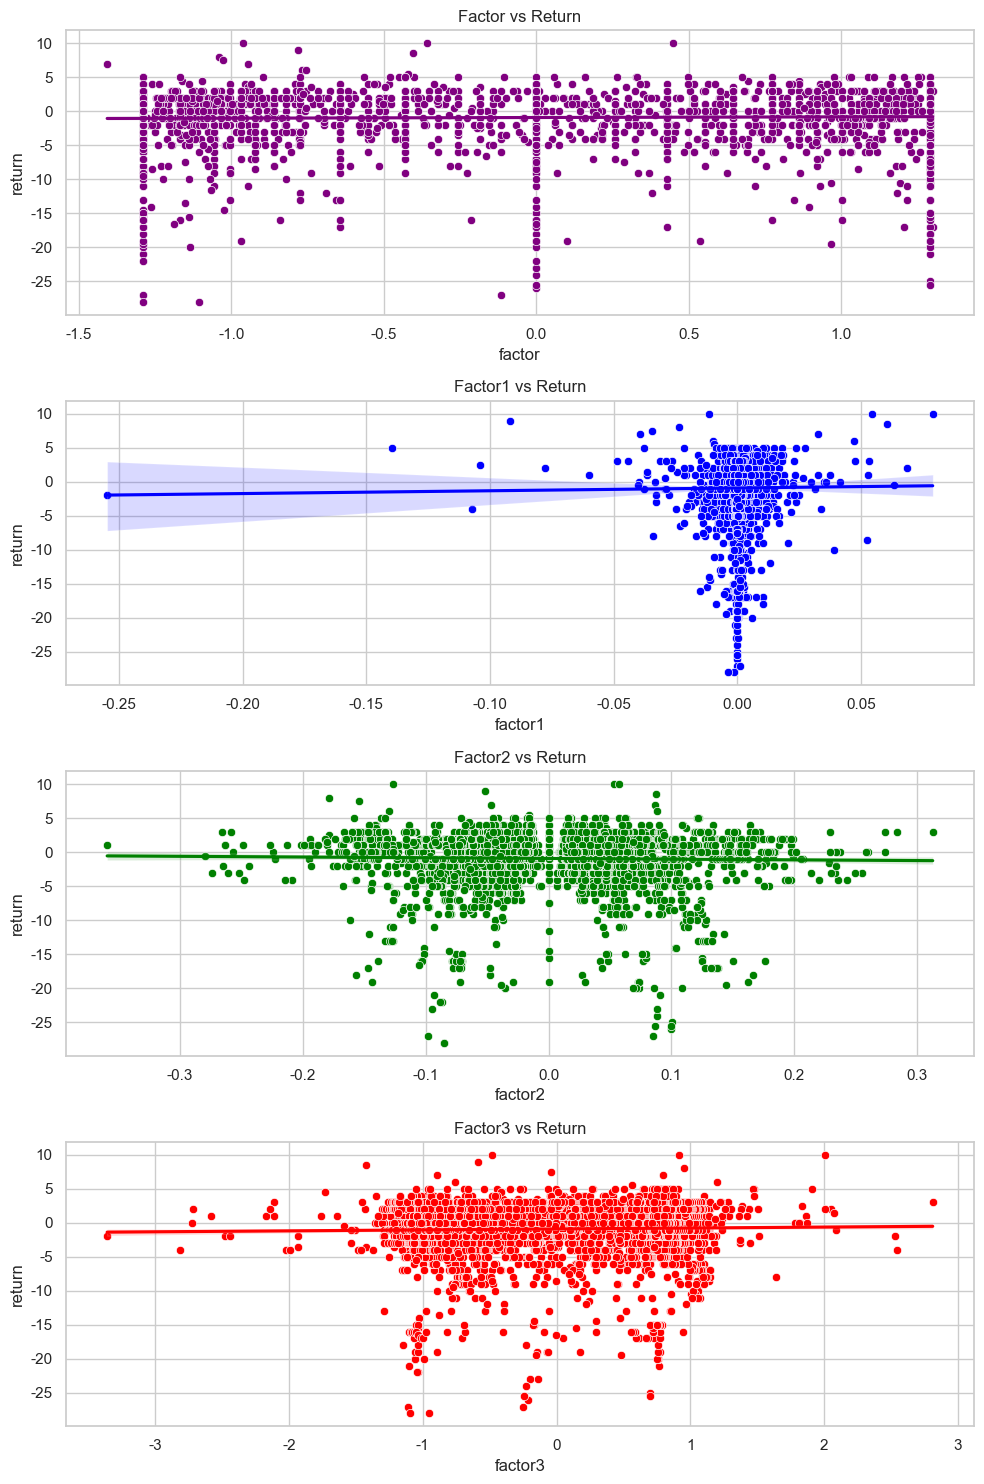

Factor 与 Return 的相关性: 0.02547818037407176
Factor1 与 Return 的相关性: 0.008008159624076134
Factor2 与 Return 的相关性: -0.019989141326157284
Factor3 与 Return 的相关性: 0.028723726245801676


In [289]:
# 假设 new_table 已经包含了 'factor1', 'factor2', 'factor3', 'return' 等列
# 确保数据中没有缺失值
# new_table_cleaned = filtered_table[['factor1', 'factor2', 'factor3','factor4','return']].dropna()
new_table_cleaned = filtered_table[['factor', 'factor1','factor2', 'factor3','return']].dropna()
# 设置绘图风格
sns.set(style="whitegrid")

# 创建一个画布和子图（3行1列的图，方便展示每个因子与return的关系）
fig, axs = plt.subplots(4, 1, figsize=(10, 15))

# 绘制 factor 与 return 的散点图
sns.scatterplot(data=new_table_cleaned, x='factor', y='return', ax=axs[0], color='purple')
axs[0].set_title('Factor vs Return')

# 添加回归线
sns.regplot(x='factor', y='return', data=new_table_cleaned, ax=axs[0], scatter=False, color='purple')


# 绘制 factor1 与 return 的散点图
sns.scatterplot(data=new_table_cleaned, x='factor1', y='return', ax=axs[1], color='blue')
axs[1].set_title('Factor1 vs Return')

# 添加回归线
sns.regplot(x='factor1', y='return', data=new_table_cleaned, ax=axs[1], scatter=False, color='blue')

# 绘制 factor2 与 return 的散点图
sns.scatterplot(data=new_table_cleaned, x='factor2', y='return', ax=axs[2], color='green')
axs[2].set_title('Factor2 vs Return')

# 添加回归线
sns.regplot(x='factor2', y='return', data=new_table_cleaned, ax=axs[2], scatter=False, color='green')

# 绘制 factor3 与 return 的散点图
sns.scatterplot(data=new_table_cleaned, x='factor3', y='return', ax=axs[3], color='red')
axs[3].set_title('Factor3 vs Return')

# 添加回归线
sns.regplot(x='factor3', y='return', data=new_table_cleaned, ax=axs[3], scatter=False, color='red')

# # 绘制 factor4 与 return 的散点图
# sns.scatterplot(data=new_table_cleaned, x='adjusted_factor', y='return', ax=axs[3], color='black')
# axs[3].set_title('adjusted_factor vs Return')

# # 添加回归线
# sns.regplot(x='adjusted_factor', y='return', data=new_table_cleaned, ax=axs[3], scatter=False, color='black')

# # 绘制 factor4 与 return 的散点图
# sns.scatterplot(data=new_table_cleaned, x='factor4', y='return', ax=axs[3], color='black')
# axs[3].set_title('Factor4 vs Return')

# # 添加回归线
# sns.regplot(x='factor4', y='return', data=new_table_cleaned, ax=axs[3], scatter=False, color='black')



# 调整子图布局
plt.tight_layout()
plt.show()

# 如果需要，计算并显示每个因子与收益之间的相关性系数
correlation_factor = np.corrcoef(new_table_cleaned['factor'], new_table_cleaned['return'])[0, 1]
correlation_factor1 = np.corrcoef(new_table_cleaned['factor1'], new_table_cleaned['return'])[0, 1]
correlation_factor2 = np.corrcoef(new_table_cleaned['factor2'], new_table_cleaned['return'])[0, 1]
correlation_factor3 = np.corrcoef(new_table_cleaned['factor3'], new_table_cleaned['return'])[0, 1]

print(f"Factor 与 Return 的相关性: {correlation_factor}")
print(f"Factor1 与 Return 的相关性: {correlation_factor1}")
print(f"Factor2 与 Return 的相关性: {correlation_factor2}")
print(f"Factor3 与 Return 的相关性: {correlation_factor3}")


In [290]:
# 对数据进行处理
# grouped_table = table.groupby('trading_date')
# grouped_table = grouped_table.filter(lambda x: x['trading_date'].iloc[0] != pd.to_datetime('2024-04-08') and x['trading_date'].iloc[0] != pd.to_datetime('2024-05-20'))
#删除 'trading_date' 为 '2024-04-08' 和 '2024-05-20' 的行
table['trading_date'] = pd.to_datetime(table['trading_date'])
# 删除 'trading_date' 为 '2024-04-08' 和 '2024-05-20' 的行
new_table = table[~table['trading_date'].isin([pd.to_datetime('2024-04-08'), pd.to_datetime('2024-05-20')])]
new_table = table.groupby('trading_date').apply(process_day, prev_period=120, back_period=120)


In [291]:
new_table['Base_factor'] = (new_table['AskVolume1']-new_table['BidVolume1'])/(new_table['AskVolume1']+new_table['BidVolume1'])
new_table['Base_factor'].replace([np.inf, -np.inf], np.nan, inplace=True)
new_table['Base_factor'].fillna(0,inplace=True)

ic_value = calculate_ic(new_table['Base_factor'],new_table['return'])
print(f'经典因子的 IC 值：{ic_value}')

经典因子的 IC 值：-0.05111585471315577


In [292]:
# factor_cols = ['factor','factor1','factor2','factor3','factor4']

# #创建滞后特征
# window_size1 = 10
# window_size2 = 10
# table = create_lagged_features(table, window_size1,window_size2)
# factor_cols.extend([col for col in table.columns if 'factor_lag' in col or 'factor1_lag' in col])

factor_cols = ['factor','factor1','factor2','factor3']
ic_value = calculate_ic_multiple_factors(new_table[factor_cols],new_table['return'])
print(f"该多因子模型 IC 值为：{ic_value}")

该多因子模型 IC 值为：0.03520924407583653


In [293]:
factor_cols.append("return")
new_table[factor_cols].corr()

,factor,factor1,factor2,factor3,return
factor,1.000000,0.108493,0.461986,0.496363,0.018876
factor1,0.108493,1.000000,0.272010,-0.088489,0.012729
factor2,0.461986,0.272010,1.000000,0.415567,0.012527
factor3,0.496363,-0.088489,0.415567,1.000000,0.030866
return,0.018876,0.012729,0.012527,0.030866,1.000000


In [294]:
# def optimize_hyperparameters(params):
#     """
#     目标函数：根据超参数优化计算 IC。
    
#     参数:
#     params: 当前的超参数组合（来自 Hyperopt）。
    
#     返回:
#     float: 负的 IC 值，因为 Hyperopt 是最小化目标函数。
#     """
#     n_estimators = int(params['n_estimators'])  # XGBoost树的数量
#     max_depth = int(params['max_depth'])  # XGBoost树的最大深度
#     learning_rate = params['learning_rate']  # 学习率
    
    
#     # 获取所有滞后因子列
#     factor_cols = ['factor','factor1','factor2','factor3']
    
#     # 选择特征 X 和目标 y
#     X = new_table[factor_cols]  # 特征矩阵
#     y = new_table['return']  # 未来回报


#     # 数据标准化
#     scaler = StandardScaler()
#     X_scaled = scaler.fit_transform(X)
    
#     # 拆分训练集和测试集
#     X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, shuffle=False)


#     # 创建XGBoost模型
#     model = xgb.XGBRegressor(
#         objective='reg:squarederror',  # 回归问题
#         n_estimators=n_estimators,
#         max_depth=max_depth,
#         learning_rate=learning_rate,
#         subsample=0.8,
#         colsample_bytree=0.8,
#         n_jobs=-1
#     )
    

#     # 训练模型
#     model.fit(X_train, y_train)


#     # 预测结果
#     y_pred = model.predict(X_train)

#     # 计算IC（预测值与实际收益的皮尔逊相关系数）
#     ic = calculate_ic(y_pred, y_train)



#     # 返回负值，因为 Hyperopt 最小化目标，我们希望最大化 IC
#     return -ic


In [295]:
# # 超参数空间定义
# space = {
#     'n_estimators': hp.randint('n_estimators', 1,100),  # 树的数量
#     'max_depth': hp.choice('max_depth', [1,2,3]),  # 树的最大深度
#     'learning_rate': hp.uniform('learning_rate', 0.01, 0.1)  # 学习率
# }


# # 最大评估次数
# max_evals = 50

# # 使用 Hyperopt 进行优化
# trials = Trials()
# best = fmin(fn=optimize_hyperparameters,  # 优化目标函数
#             space=space,  # 搜索空间
#             algo=tpe.rand.suggest,  # 使用贝叶斯优化算法
#             max_evals=max_evals,  # 最大评估次数
#             trials=trials)  # 记录所有试验

# print("最佳超参数配置:", best)

In [296]:
# # 获取所有滞后因子列
# factor_cols = ['factor','factor1','factor2','factor3']

# # 选择特征 X 和目标 y
# X = new_table[factor_cols]  # 特征矩阵
# y = new_table['return']  # 未来回报


# # 数据标准化
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

# # 拆分训练集和测试集
# X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, shuffle=False)

# # 创建 XGBoost 模型
# model = xgb.XGBRegressor(
#     objective='reg:squarederror',  # 回归问题
#     n_estimators=best['n_estimators'],
#     max_depth=best['max_depth'],
#     learning_rate=best['learning_rate'],
#     subsample=0.8,
#     colsample_bytree=0.8,
#     n_jobs=-1
# )

# # 训练模型
# model.fit(X_train, y_train)

# # 在测试集上进行预测
# y_pred = model.predict(X_test)

# ic_value = calculate_ic(y_pred, y_test)
# print(f"测试集上的 IC 值: {ic_value}")